In [ ]:
########now part 2: decode and train#######

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3625252946920903512
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11272650752
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3594027441480131163
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import math
import timeit
import matplotlib.pyplot as plt
from tensorflow.contrib.layers.python.layers import utils
#from preprocess_func_new import *
from matplotlib.image import imread
import os
from os.path import expanduser
# from tensorflow.python import keras
# from tensorflow.keras.applications.mobileNet import DepthwiseConv2D

%matplotlib inline

#tf.enable_eager_execution()

#tf.logging.set_verbosity(tf.logging.INFO)

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
img_path = os.path.join('..','datasets2','stixels')
img_path

'../datasets2/stixels'

In [3]:
percent=2 

In [4]:
tfrec_batch_size=1 #for path name only

In [5]:
batch_size=64

In [6]:
tfrec_train_directory = os.path.join('..','datasets2','stixels','train','tfrec_batch_size_'
                                     +str(tfrec_batch_size)+'_percent_'+str(percent))
#### note there is a misspelling "precent"
tfrec_train_directory


'../datasets2/stixels/train/tfrec_batch_size_1_percent_2'

In [7]:
#creating a list of paths to train tfrecs:
path_tfrecords_train_lst=[]
path_tfrecords_train = os.path.join(img_path, 'train')
for root, dirs, files in os.walk(tfrec_train_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_train_lst.append(os.path.join(tfrec_train_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')


In [8]:
len(path_tfrecords_train_lst)

398578

In [10]:
#shortening the list for experiments
path_tfrecords_train_lst = path_tfrecords_train_lst[:128]
##################

In [11]:
#params
H=370 
W=24
C=3
img_shape = (H, W, C)
num_classes = 17

In [10]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    #######image = tf.decode_raw(image_raw, tf.int32) ####
    image = tf.image.decode_png(image_raw, channels=3, dtype=tf.uint8) 
    #image = tf.cast(image, tf.int32)

    # The type is now uint8 but we need it to be float.
    
    image = tf.cast(image, tf.float32) ####
    
    # Get the label associated with the image.
    label = parsed_example['label']
    
    
    # The image and label are now correct TensorFlow types.
    return image, label

In [15]:
len(path_tfrecords_train_lst)

398578

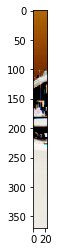

In [45]:
####
plt.imshow(a)

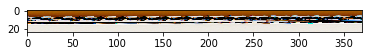

In [43]:
####
plt.imshow(b)

In [18]:
def input_fn(filenames, train, batch_size=batch_size, buffer_size=100000): 
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)
    
    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        ######dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    #dataset = dataset.batch(batch_size)
    #dataset = tf.contrib.data.batch_and_drop_remainder(batch_size)
    dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    print('@@@')
    print(dataset.output_shapes)  # ==> "(16,)" (the batch dimension is known)
    print('@@@')
    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch
    return x, y

In [19]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train_lst, train=True)

In [20]:
# the next four cells are a modification of https://github.com/xiaochus/MobileNetV2/blob/master/mobilenet_v2.py
def _conv_block(inputs, filters, kernel, strides, is_training):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """
    x = tf.layers.conv2d(inputs=inputs, 
                         filters=filters, 
                         kernel_size=kernel,
                         activation=None, 
                         strides=strides,
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                         padding='same'
                        )
    
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    
    x = tf.nn.relu6(features=x)
       
    return x


In [21]:
def _bottleneck(inputs, filters, kernel, t, s, is_training, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    
    num_filters_in = utils.last_dimension(inputs.get_shape(), min_rank=4)
    
    # "Expension layer" + BN + activation
    x = _conv_block(inputs=inputs, 
                    filters=num_filters_in*t, 
                    kernel=(1, 1), 
                    strides=(1, 1), 
                    is_training=is_training)
    
    # Depthwise convolution + BN + activation
    x = tf.contrib.layers.separable_conv2d(inputs=x,
                                           num_outputs=None,
                                           kernel_size=kernel,
                                           depth_multiplier=1,
                                           stride=(s,s),
                                           padding='SAME',
                                           activation_fn=tf.nn.relu6,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                           normalizer_fn=None
                                          )
     
    x = tf.layers.batch_normalization(inputs=x, 
                                      training=is_training
                                     )
    
    x = tf.nn.relu6(features=x)
    
    # "Projection" layer + BN
    x = tf.layers.conv2d(inputs=x,
                         filters = filters,
                         kernel_size = (1, 1),
                         strides=(1, 1),
                         padding='same',
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                        )
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    
    if r:
        x = tf.add(x, inputs)
        
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t
    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))
    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    '''
    
    return x


In [22]:
def _inverted_residual_block(inputs, filters, kernel, t, strides, n, is_training):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs=inputs, 
                    filters=filters, 
                    kernel=kernel, 
                    t=t, 
                    s=strides, 
                    is_training=is_training
                   )
        
    for i in range(1, n):
        x = _bottleneck(inputs=x, 
                        filters=filters, 
                        kernel=kernel, 
                        t=t, 
                        s=1, 
                        is_training=is_training, 
                        r=True
                       )

    return x


In [23]:
def MobileNetV2(inputs, k, is_training):
    """MobileNetV2
    This function defines a MobileNetV2 architectures.
    # Arguments
        inputs: A tensor of the input of shape [-1,W,H,C].
        k: Integer, number of classes.
        is_training: boolean indication training or prediction
    # Returns
        MobileNetV2 model.
    """

    
    
    
    x = _conv_block(inputs=inputs, filters=32, kernel=(3, 3), strides=(2, 2), is_training=is_training)
        
    x = _inverted_residual_block(inputs=x, filters=16,  kernel=(7, 3), t=1, strides=1, n=1, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=24,  kernel=(7, 3), t=6, strides=2, n=2, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=32,  kernel=(7, 3), t=6, strides=2, n=3, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=64,  kernel=(7, 3), t=6, strides=2, n=4, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=96,  kernel=(7, 3), t=6, strides=1, n=3, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=160, kernel=(3, 3), t=6, strides=2, n=3, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=320, kernel=(3, 3), t=6, strides=1, n=1, is_training=is_training)
    x = tf.layers.average_pooling2d(inputs=x, pool_size=(24,2), strides=(1,1))
    # Eventually this should be replaced with:
    x = tf.layers.flatten(x)


    # This is the last layer so it does not use an activation function.
    x = tf.layers.dense(inputs=x, name='layer_fc6',
                          units=k,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 
    '''
    x = _conv_block(inputs=x, filters=1280, kernel=(1, 1), strides=(1, 1), is_training=is_training)
    x = tf.layers.average_pooling2d(inputs=x, pool_size=(2000,2000), strides=(1,1), padding='same')
    x = tf.reshape(x, [-1,1,1,1280])
    #x = tf.layers.dropout(inputs=x, rate=0.3, seed=481, training=is_training)
    x = tf.layers.conv2d(inputs=x,
                         filters = k,
                         kernel_size = (1, 1),
                         padding='same',
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                        )
    '''
    '''
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1280))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)
    '''
    

    return x

In [24]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
   
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_training = True
    else:
        is_training = False
    
    # Reference to the tensor named "image" in the input-function.    
    x = features["image"]
    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    inputs = tf.reshape(x, [-1,H,W,C]) #!!!!! this is how it shpukd be!!!
    
    net = MobileNetV2(inputs=inputs, k=17, is_training=is_training)
    
    
    
    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1) 
   
    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred) #_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        tf.argmax(logits)
        #loss = tf.losses.mean_squared_error(labels=labels, predictions=logits)
        loss = tf.reduce_mean(cross_entropy)
#######################
        lr = 1e-4
        step_rate = 5000
        decay = 0.7 #if this equals 1 the lr stays the same

        #global_step = tf.Variable(0, trainable=False)
        #increment_global_step = tf.assign(global_step, global_step + 1)

        learning_rate = tf.train.exponential_decay(lr, global_step=tf.train.get_or_create_global_step(), 
                                           decay_steps=step_rate, decay_rate=decay, staircase=True)
        
        # Define the optimizer for improving the neural network.
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#         optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) 
        
        ''' original
        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_or_create_global_step())
        '''
        # for learning parameters of batch normalization:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
        
        
#############################        


        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls) #TODO change acc method
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)


        tf.summary.scalar("accuracy", metrics["accuracy"][1]) 
        merge_summary_op = tf.summary.merge_all()


            
    return spec

In [25]:
params = {} #{"learning_rate": 1e-5}

In [27]:
def make_dir_and_comment(model_dir):
    home = expanduser("~")
    log_name=os.path.join('logs/', model_dir + '.txt')
    
    if os.path.isdir(model_dir):
        print('INFO: dir with name ' + model_dir + ' already exist.')
    
    new_comment=input('Please add a comment\n')
    
    if os.path.exists(log_name):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    
    model_log = open(log_name,append_write)
    model_log.write(home +' : '+ new_comment + '\n')
    model_log.close()
    return



In [28]:
model_dir = './ckpts_30_5_mobilenetV2_17bins_04_swap' #'./ckpts_<day>_<month>_<architecture>_<main_change>'
make_dir_and_comment(model_dir) 
# model = tf.estimator.Estimator(model_fn=model_fn,
#                                params=params,
#                                model_dir=model_dir)

model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir=model_dir,
                               config=tf.estimator.RunConfig().replace(save_checkpoints_steps=1000,save_summary_steps=10)
                              )

INFO: dir with name ./ckpts_30_5_mobilenetV2_17bins_04_swap already exist.
Please add a comment
check val and acc
INFO:tensorflow:Using config: {'_model_dir': './ckpts_30_5_mobilenetV2_17bins_04_swap', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f35cc649e10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [30]:
model.train(input_fn=train_input_fn, steps=80000)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt.
INFO:tensorflow:loss = 3.3201184, step = 0
INFO:tensorflow:global_step/sec: 3.38847
INFO:tensorflow:loss = 2.8107905, step = 100 (29.514 sec)
INFO:tensorflow:global_step/sec: 4.19405
INFO:tensorflow:loss = 2.6745446, step = 200 (23.842 sec)
INFO:tensorflow:global_step/sec: 4.17887
INFO:tensorflow:loss = 2.6684816, step = 300 (23.931 sec)
INFO:tensorflow:global_step/sec: 4.18192
INFO:tensorflow:loss = 2.5369434, step = 400 (23.912 sec)
INFO:tensorflow:global_step/sec: 4.1928
INFO:tensorflow:loss = 2.4384418, step = 500 (23.852 sec)
INFO:tensor

INFO:tensorflow:loss = 0.7437935, step = 7000 (25.211 sec)
INFO:tensorflow:global_step/sec: 4.23716
INFO:tensorflow:loss = 0.97527134, step = 7100 (23.601 sec)
INFO:tensorflow:global_step/sec: 4.21919
INFO:tensorflow:loss = 0.7110128, step = 7200 (23.702 sec)
INFO:tensorflow:global_step/sec: 4.21672
INFO:tensorflow:loss = 0.7615856, step = 7300 (23.717 sec)
INFO:tensorflow:global_step/sec: 4.20297
INFO:tensorflow:loss = 1.0250945, step = 7400 (23.791 sec)
INFO:tensorflow:global_step/sec: 4.20675
INFO:tensorflow:loss = 0.91330755, step = 7500 (23.771 sec)
INFO:tensorflow:global_step/sec: 4.20577
INFO:tensorflow:loss = 0.83732325, step = 7600 (23.777 sec)
INFO:tensorflow:global_step/sec: 4.19926
INFO:tensorflow:loss = 0.8129958, step = 7700 (23.815 sec)
INFO:tensorflow:global_step/sec: 4.20389
INFO:tensorflow:loss = 0.6677313, step = 7800 (23.787 sec)
INFO:tensorflow:global_step/sec: 4.19364
INFO:tensorflow:loss = 0.67399323, step = 7900 (23.846 sec)
INFO:tensorflow:Saving checkpoints fo

INFO:tensorflow:global_step/sec: 4.19864
INFO:tensorflow:loss = 0.6677182, step = 14500 (23.815 sec)
INFO:tensorflow:global_step/sec: 4.23331
INFO:tensorflow:loss = 0.69164926, step = 14600 (23.622 sec)
INFO:tensorflow:global_step/sec: 4.21875
INFO:tensorflow:loss = 0.8924317, step = 14700 (23.704 sec)
INFO:tensorflow:global_step/sec: 4.2151
INFO:tensorflow:loss = 0.74017763, step = 14800 (23.725 sec)
INFO:tensorflow:global_step/sec: 4.1974
INFO:tensorflow:loss = 0.71639526, step = 14900 (23.823 sec)
INFO:tensorflow:Saving checkpoints for 15001 into ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt.
INFO:tensorflow:global_step/sec: 3.94098
INFO:tensorflow:loss = 0.5083695, step = 15000 (25.376 sec)
INFO:tensorflow:global_step/sec: 4.21147
INFO:tensorflow:loss = 0.69907665, step = 15100 (23.743 sec)
INFO:tensorflow:global_step/sec: 4.23594
INFO:tensorflow:loss = 0.76959765, step = 15200 (23.608 sec)
INFO:tensorflow:global_step/sec: 4.23336
INFO:tensorflow:loss = 0.86674356, step = 1530

INFO:tensorflow:global_step/sec: 4.20215
INFO:tensorflow:loss = 0.8030175, step = 21900 (23.796 sec)
INFO:tensorflow:Saving checkpoints for 22001 into ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt.
INFO:tensorflow:global_step/sec: 3.95939
INFO:tensorflow:loss = 0.58521456, step = 22000 (25.258 sec)
INFO:tensorflow:global_step/sec: 4.20059
INFO:tensorflow:loss = 0.7134532, step = 22100 (23.806 sec)
INFO:tensorflow:global_step/sec: 4.20656
INFO:tensorflow:loss = 0.6100588, step = 22200 (23.772 sec)
INFO:tensorflow:global_step/sec: 4.20139
INFO:tensorflow:loss = 0.7493323, step = 22300 (23.802 sec)
INFO:tensorflow:global_step/sec: 4.21287
INFO:tensorflow:loss = 0.6754164, step = 22400 (23.736 sec)
INFO:tensorflow:global_step/sec: 4.20717
INFO:tensorflow:loss = 0.47564173, step = 22500 (23.770 sec)
INFO:tensorflow:global_step/sec: 4.1961
INFO:tensorflow:loss = 0.8495486, step = 22600 (23.830 sec)
INFO:tensorflow:global_step/sec: 4.22637
INFO:tensorflow:loss = 0.603942, step = 22700 (2

INFO:tensorflow:global_step/sec: 4.23441
INFO:tensorflow:loss = 0.719542, step = 29200 (23.617 sec)
INFO:tensorflow:global_step/sec: 4.21535
INFO:tensorflow:loss = 0.62401, step = 29300 (23.722 sec)
INFO:tensorflow:global_step/sec: 4.21538
INFO:tensorflow:loss = 0.57100797, step = 29400 (23.722 sec)
INFO:tensorflow:global_step/sec: 4.20478
INFO:tensorflow:loss = 0.49167806, step = 29500 (23.783 sec)
INFO:tensorflow:global_step/sec: 4.20331
INFO:tensorflow:loss = 0.69281733, step = 29600 (23.791 sec)
INFO:tensorflow:global_step/sec: 4.22792
INFO:tensorflow:loss = 0.56632787, step = 29700 (23.651 sec)
INFO:tensorflow:global_step/sec: 4.20222
INFO:tensorflow:loss = 0.86731213, step = 29800 (23.799 sec)
INFO:tensorflow:global_step/sec: 4.1968
INFO:tensorflow:loss = 0.6830642, step = 29900 (23.828 sec)
INFO:tensorflow:Saving checkpoints for 30001 into ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt.
INFO:tensorflow:global_step/sec: 3.96024
INFO:tensorflow:loss = 0.37605512, step = 30000 

INFO:tensorflow:global_step/sec: 4.21318
INFO:tensorflow:loss = 0.72202146, step = 36600 (23.735 sec)
INFO:tensorflow:global_step/sec: 4.19196
INFO:tensorflow:loss = 0.52612877, step = 36700 (23.855 sec)
INFO:tensorflow:global_step/sec: 4.21733
INFO:tensorflow:loss = 0.67881644, step = 36800 (23.713 sec)
INFO:tensorflow:global_step/sec: 4.20926
INFO:tensorflow:loss = 0.4512875, step = 36900 (23.756 sec)
INFO:tensorflow:Saving checkpoints for 37001 into ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt.
INFO:tensorflow:global_step/sec: 3.94541
INFO:tensorflow:loss = 0.58650386, step = 37000 (25.348 sec)
INFO:tensorflow:global_step/sec: 4.19996
INFO:tensorflow:loss = 0.53106964, step = 37100 (23.808 sec)
INFO:tensorflow:global_step/sec: 4.2117
INFO:tensorflow:loss = 0.48483926, step = 37200 (23.745 sec)
INFO:tensorflow:global_step/sec: 4.21977
INFO:tensorflow:loss = 0.705178, step = 37300 (23.697 sec)
INFO:tensorflow:global_step/sec: 4.22075
INFO:tensorflow:loss = 0.45807526, step = 374

INFO:tensorflow:Saving checkpoints for 44001 into ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt.
INFO:tensorflow:global_step/sec: 3.96872
INFO:tensorflow:loss = 0.5683665, step = 44000 (25.197 sec)
INFO:tensorflow:global_step/sec: 4.20646
INFO:tensorflow:loss = 0.67191225, step = 44100 (23.775 sec)
INFO:tensorflow:global_step/sec: 4.19071
INFO:tensorflow:loss = 0.61610997, step = 44200 (23.862 sec)
INFO:tensorflow:global_step/sec: 4.18725
INFO:tensorflow:loss = 0.65035135, step = 44300 (23.881 sec)
INFO:tensorflow:global_step/sec: 4.19825
INFO:tensorflow:loss = 0.4237627, step = 44400 (23.820 sec)
INFO:tensorflow:global_step/sec: 4.21479
INFO:tensorflow:loss = 0.6112587, step = 44500 (23.726 sec)
INFO:tensorflow:global_step/sec: 4.21582
INFO:tensorflow:loss = 0.6452984, step = 44600 (23.720 sec)
INFO:tensorflow:global_step/sec: 4.19844
INFO:tensorflow:loss = 0.5682125, step = 44700 (23.817 sec)
INFO:tensorflow:global_step/sec: 4.19444
INFO:tensorflow:loss = 0.6448804, step = 44800

INFO:tensorflow:global_step/sec: 4.21739
INFO:tensorflow:loss = 0.73073405, step = 51300 (23.711 sec)
INFO:tensorflow:global_step/sec: 4.1953
INFO:tensorflow:loss = 0.5596378, step = 51400 (23.836 sec)
INFO:tensorflow:global_step/sec: 4.19824
INFO:tensorflow:loss = 0.5261724, step = 51500 (23.821 sec)
INFO:tensorflow:global_step/sec: 4.21799
INFO:tensorflow:loss = 0.53819466, step = 51600 (23.707 sec)
INFO:tensorflow:global_step/sec: 4.21221
INFO:tensorflow:loss = 0.6154359, step = 51700 (23.741 sec)
INFO:tensorflow:global_step/sec: 4.19823
INFO:tensorflow:loss = 0.69103277, step = 51800 (23.819 sec)
INFO:tensorflow:global_step/sec: 4.19897
INFO:tensorflow:loss = 0.69085765, step = 51900 (23.817 sec)
INFO:tensorflow:Saving checkpoints for 52001 into ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt.
INFO:tensorflow:global_step/sec: 3.95453
INFO:tensorflow:loss = 0.63180834, step = 52000 (25.286 sec)
INFO:tensorflow:global_step/sec: 4.20676
INFO:tensorflow:loss = 0.46252513, step = 521

INFO:tensorflow:global_step/sec: 4.21379
INFO:tensorflow:loss = 0.6365558, step = 58700 (23.730 sec)
INFO:tensorflow:global_step/sec: 4.2215
INFO:tensorflow:loss = 0.36408815, step = 58800 (23.690 sec)
INFO:tensorflow:global_step/sec: 4.21097
INFO:tensorflow:loss = 0.40369758, step = 58900 (23.746 sec)
INFO:tensorflow:Saving checkpoints for 59001 into ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt.
INFO:tensorflow:global_step/sec: 3.97568
INFO:tensorflow:loss = 0.46668738, step = 59000 (25.153 sec)
INFO:tensorflow:global_step/sec: 4.19991
INFO:tensorflow:loss = 0.480295, step = 59100 (23.810 sec)
INFO:tensorflow:global_step/sec: 4.19166
INFO:tensorflow:loss = 0.69527805, step = 59200 (23.858 sec)
INFO:tensorflow:global_step/sec: 4.19996
INFO:tensorflow:loss = 0.6076047, step = 59300 (23.809 sec)
INFO:tensorflow:global_step/sec: 4.20856
INFO:tensorflow:loss = 0.46215063, step = 59400 (23.760 sec)
INFO:tensorflow:global_step/sec: 4.2084
INFO:tensorflow:loss = 0.47361493, step = 59500

INFO:tensorflow:global_step/sec: 3.9605
INFO:tensorflow:loss = 0.45025647, step = 66000 (25.249 sec)
INFO:tensorflow:global_step/sec: 4.21235
INFO:tensorflow:loss = 0.566395, step = 66100 (23.741 sec)
INFO:tensorflow:global_step/sec: 4.20142
INFO:tensorflow:loss = 0.47001827, step = 66200 (23.802 sec)
INFO:tensorflow:global_step/sec: 4.19798
INFO:tensorflow:loss = 0.43231675, step = 66300 (23.821 sec)
INFO:tensorflow:global_step/sec: 4.20998
INFO:tensorflow:loss = 0.70563465, step = 66400 (23.753 sec)
INFO:tensorflow:global_step/sec: 4.20322
INFO:tensorflow:loss = 0.4761405, step = 66500 (23.790 sec)
INFO:tensorflow:global_step/sec: 4.2094
INFO:tensorflow:loss = 0.33890712, step = 66600 (23.758 sec)
INFO:tensorflow:global_step/sec: 4.21029
INFO:tensorflow:loss = 0.41855392, step = 66700 (23.751 sec)
INFO:tensorflow:global_step/sec: 4.21108
INFO:tensorflow:loss = 0.5681325, step = 66800 (23.747 sec)
INFO:tensorflow:global_step/sec: 4.21064
INFO:tensorflow:loss = 0.4905244, step = 66900 

INFO:tensorflow:global_step/sec: 4.21416
INFO:tensorflow:loss = 0.69611156, step = 73400 (23.728 sec)
INFO:tensorflow:global_step/sec: 4.19599
INFO:tensorflow:loss = 0.46353996, step = 73500 (23.832 sec)
INFO:tensorflow:global_step/sec: 4.20657
INFO:tensorflow:loss = 0.51224256, step = 73600 (23.773 sec)
INFO:tensorflow:global_step/sec: 4.20896
INFO:tensorflow:loss = 0.38661835, step = 73700 (23.760 sec)
INFO:tensorflow:global_step/sec: 4.20943
INFO:tensorflow:loss = 0.7169579, step = 73800 (23.755 sec)
INFO:tensorflow:global_step/sec: 4.22412
INFO:tensorflow:loss = 0.46754757, step = 73900 (23.674 sec)
INFO:tensorflow:Saving checkpoints for 74001 into ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt.
INFO:tensorflow:global_step/sec: 3.96784
INFO:tensorflow:loss = 0.4947221, step = 74000 (25.204 sec)
INFO:tensorflow:global_step/sec: 4.21802
INFO:tensorflow:loss = 0.45844096, step = 74100 (23.708 sec)
INFO:tensorflow:global_step/sec: 4.2244
INFO:tensorflow:loss = 0.53297305, step = 74

In [ ]:
###DONE TRAIN###

In [23]:
#performance on training dataset:
def train_partial_input_fn():
#     return input_fn(path_tfrecords_train_lst[7000:8500], train=False) 
    return input_fn(path_tfrecords_train_lst[:500], train=False) 

train_partial_result = model.evaluate(input_fn=train_partial_input_fn) 

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-29-20:42:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_28_5_mobilenetV2_15bins_02/model.ckpt-81006
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-29-20:42:48
INFO:tensorflow:Saving dict for global step 81006: accuracy = 0.6651786, global_step = 81006, loss = 0.9127394


In [ ]:
#VAL:

In [29]:
tfrec_val_batch_size=1

In [30]:
tfrec_val_directory = os.path.join('..','datasets2','stixels','val','tfrec_batch_size_'+str(tfrec_val_batch_size))#+'_percent_'+str(percent))

In [31]:
path_tfrecords_val_lst=[]
path_tfrecords_val = os.path.join(img_path, 'val')
for root, dirs, files in os.walk(tfrec_val_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_val_lst.append(os.path.join(tfrec_val_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [32]:
len(path_tfrecords_val_lst)

117915

In [33]:
def val_input_fn():
    return input_fn(path_tfrecords_val_lst, train=False) 

In [37]:
val_result = model.evaluate(input_fn=val_input_fn) 

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-31-15:30:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-31-15:53:02
INFO:tensorflow:Saving dict for global step 80000: accuracy = 0.69665277, global_step = 80000, loss = 0.85510576


In [38]:
val_result

{'accuracy': 0.69665277, 'global_step': 80000, 'loss': 0.85510576}

In [39]:
print("Classification val accuracy: {0:.2%}".format(val_result["accuracy"]))

Classification val accuracy: 69.67%


In [ ]:
#TEST:

In [38]:
tfrec_test_batch_size=1

In [163]:
tfrec_test_directory = os.path.join('..','datasets2','stixels','test','tfrec_batch_size_'+str(tfrec_test_batch_size))

In [164]:
path_tfrecords_test_lst=[]
path_tfrecords_test = os.path.join(img_path, 'test')
for root, dirs, files in os.walk(tfrec_test_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_test_lst.append(os.path.join(tfrec_test_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [167]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_test_lst[1000:2500], train=False)

In [221]:
test_result = model.evaluate(input_fn=test_input_fn)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-28-15:58:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-28-15:58:25
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.18953805, global_step = 20000, loss = 2.6755853


In [109]:
print("Classification test accuracy: {0:.2%}".format(test_result["accuracy"]))

Classification test accuracy: 11.55%


In [ ]:
#PRED:

In [62]:
sum_csv_test_path = os.path.join(img_path,'val', 'sum_csv') #TEST
labels_test=pd.read_csv(os.path.join(sum_csv_test_path,'labels_val_'+str(percent)+'percent.csv'))
test_names_list=list(labels_test['Name'])
image_paths_test=[]
for name in test_names_list:
    image_paths_test.append(os.path.join(img_path, 'val', name+'.png')) 


In [63]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    images = np.asarray(images)
    images=images*255 # Convert to a numpy array 
    return images


In [64]:
##TODO:SHUFFLE!
some_num=500
some_images = load_images(image_paths=image_paths_test[:some_num])
print(some_images.shape)
some_images_cls = np.array(labels_test['Label'][:some_num])
 

(500, 370, 24, 3)


In [66]:
some_images_cls[:224]

array([12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10,
       10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 11, 12, 12, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
       10, 10, 10])

In [67]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

In [77]:
predictions_np = model.predict(input_fn=predict_input_fn) 

In [78]:
cls_pred_np = np.array(list(predictions_np))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [80]:
cls_pred_np.shape

(500, 17)

In [84]:
cls_pred_2=np.argmax(cls_pred_np,axis=1)

In [88]:
cls_pred_2[:224]

array([ 9, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 10, 10, 10, 10,
       10, 10,  8,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  5,  5,  5,
        5,  5,  5,  5,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  4,  5,  5,  5,  5,  5,  5,  5,  6,
        8,  6,  6,  6,  6,  6,  6,  6,  6,  7, 11, 10, 11, 10, 10, 10, 10,
       10, 11, 11, 11, 10, 11, 12, 11, 10, 11, 11, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10,  9, 10, 10,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  6,  5,  5,  5,  5,  6,  5,  6,  5,  5,
        5,  5,  5,  5,  4,  4,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9, 10,  9, 10, 10, 10, 10, 10, 10, 10,  9, 10, 10, 10, 10, 10,
        9,  9, 10,  9,  9,  9,  9,  9,  9, 11,  9,  8,  8,  9,  7, 11, 10,
       10, 10, 10, 10,  9,  7, 10, 10, 10,  9,  9,  8,  7,  7,  7,  9,  9,
       10, 10, 10])

In [90]:
cls_pred_2[:224]-some_images_cls[:224]

array([-3,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -2, -2, -2, -2, -2, -2, -3, -3, -2,
        0, -2, -2, -2, -2, -2, -2, -3, -3, -3,  1,  0,  1,  0, -1, -1, -1,
       -1,  0,  0,  0, -2, -1, -4,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  6,  6,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,
       -1,  0,  0,  0,  0,  0,  0,  1,  0, -1, -1, -1,  0, -1,  0, -1, -1,
       -1, -1, -1, -1, -2, -2, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1, -1,  0,  0,  0,  0,  0,  1,  1,  0,  1,  1,  1,  1,  1,
        0,  0,  1,  0,  0,  0,  0,  0,  1,  3,  1,  0,  0,  1, -1,  3,  2,
        2,  2,  2,  2,  1, -2,  1,  1,  1,  0,  0, -1, -2, -2, -3, -1, -1,
        0,  0,  0])

In [106]:
import matplotlib.pyplot as plt
from skimage.transform import resize
def plot_im(img,cls):
    img = resize(img, (370,img.shape[1]))
    imgplot = plt.imshow(img)
    img[140+cls*15:140+(cls+1)*15,:,0]=1
    img[140+cls*15:140+(cls+1)*15,:,1:]=0
    #imgplot = plt.imshow(img)
    #plt.axis('off')
    #plt.show()
    return img[:,:5,:]
    

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


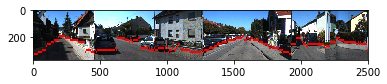

In [120]:
#plotting our preds:
some_images_for_plt = some_images[:]/255.0
img = np.ones([370, 1, 3])
for im in range(cls_pred_2[:].shape[0]):
    img0 = plot_im(some_images_for_plt[im,:,:,:], cls_pred_2[im])
    img=np.concatenate([img,img0],axis=1)
imgplot = plt.imshow(img)
plt.show()


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


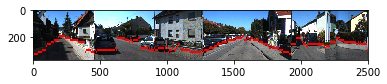

In [121]:
some_images_for_plt = some_images[:]/255.0
img = np.ones([370, 1, 3])
for im in range(some_images_cls[:].shape[0]):
    img0 = plot_im(some_images_for_plt[im,:,:,:], cls_pred_2[im])
    img=np.concatenate([img,img0],axis=1)
imgplot = plt.imshow(img)
plt.show()


In [ ]:
#plotting our preds: with axes
some_images_for_plt = some_images[:1000]/255.0
for im in range(cls_pred.shape[0]):
    plot_im(some_images_for_plt[im,:,:,:], y_pred_cls[im])


In [ ]:
#plotting ground truth:
for im in range(cls_pred.shape[0]):
    plot_im(some_images_for_plt[im,:,:,:], some_images_cls[im])

In [ ]:
#plot without mark
for im in range(cls_pred.shape[0]):
    plot_im(some_images_for_plt[im,:,:,:], 16)

In [ ]:
np.histogram(y_pred_cls, bins= [x for x in range(0, 17, 1)])


In [78]:
np.histogram(cls_pred, bins= [x for x in range(0, 17, 1)])


(array([  0,   0,   0,   5,  35,   6,   1,   2,  24,  12,  27, 188, 103,
          0,   0,  97]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]))

In [38]:
#extract ground truth data
dataset = tf.data.TFRecordDataset(filenames=path_tfrecords_val_lst)
dataset = dataset.map(parse)
iterator = dataset.make_one_shot_iterator()
images_batch, labels_batch = iterator.get_next()
x = {'image': images_batch}
y = labels_batch
GTlabels=[]
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    for i in range(len(path_tfrecords_val_lst)):
        sess.run(init_op)
        GTlabels.append(sess.run(y))

In [50]:
GTlabels = GTlabels[:117888]
len(GTlabels)

117888

In [51]:
df = pd.DataFrame(GTlabels, columns=['GT'])

In [53]:
pd.DataFrame.to_csv(df,'VAL_GT')

In [44]:
predictions = model.predict(input_fn=val_input_fn)

In [45]:
cls_pred = list(predictions)
len(cls_pred)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_30_5_mobilenetV2_17bins_04_swap/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


117888

In [55]:
cls_pred_2=np.argmax(cls_pred, axis=1)

In [56]:
len(cls_pred_2)

117888

In [46]:
len(GTlabels)

117915

In [57]:
df2=pd.DataFrame(cls_pred_2, columns=['preds'])

In [59]:
pd.DataFrame.to_csv(df2,'PREDS.csv')